In [ ]:
# Instalación de dependencias
!pip install datasets transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.4 MB/s eta 0:00:00


## 1. Introducción y Objetivos

**¿De qué trata este taller?**

Este taller introduce a los participantes en la clasificación de mensajes SMS como spam o no spam (ham) utilizando técnicas de Procesamiento del Lenguaje Natural (NLP).  Aprenderemos a construir modelos que puedan distinguir automáticamente entre mensajes deseados y no deseados.

**¿Qué aprenderemos?**

*   **Ciclo Completo de NLP:** Cubriremos el ciclo completo de un proyecto de NLP, desde la exploración y preprocesamiento de los datos, hasta el entrenamiento, validación y evaluación de los modelos.

*   **Modelos Clásicos vs. Deep Learning:** Exploraremos tanto modelos tradicionales de Machine Learning como modelos más avanzados de Deep Learning, incluyendo Redes Neuronales Recurrentes (LSTM) y Transformers (BERT), para comprender sus ventajas y desventajas en la clasificación de texto.

*   **Fine tuning de BERT:**  Aprenderemos a realizar un fine tuning de BERT, uno de los modelos de lenguaje más potentes disponibles, para nuestra tarea específica de clasificación de spam.

*   **Predicción con Nuevos Datos:**  Finalmente, aprenderemos a utilizar nuestros modelos entrenados para realizar predicciones sobre nuevos mensajes SMS.

**Descripción del Dataset: SMS Spam Collection**

Utilizaremos el dataset "SMS Spam Collection". Este dataset contiene mensajes SMS etiquetados como spam (1) o no spam (0). Es un dataset estándar en la comunidad de NLP y permite a los participantes trabajar con datos reales y representativos.

## 2. Carga del Dataset

Aquí descargaremos las stopwords (palabras comunes que no aportan mucho significado) del paquete nltk y cargaremos el dataset sms_spam usando la librería datasets de Hugging Face.

In [ ]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords de NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from datasets import load_dataset

# Cargar el dataset 'sms_spam' e imprimirlo para ver el formato
dataset = load_dataset('sms_spam')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/359k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sms', 'label'],
        num_rows: 5574
    })
})

Luego, convertiremos el dataset a un DataFrame de Pandas para facilitar su manipulación y exploración.

In [ ]:
import pandas as pd

# Crear un dataframe con el dataset
df = pd.DataFrame(dataset['train'])

# Renombrar la columna 'sms' a 'text'
df = df.rename(columns={'sms': 'text'})

# Cambiar el tipo de dato de 'label' a integer
df = df.astype({'label': 'int'})

# Mostrar las 5 primeras filas
df.head(5)

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


Finalmente, imprimiremos información básica sobre el dataset, como el número de filas y columnas, los tipos de datos y la distribución de las etiquetas.  También mostraremos ejemplos de mensajes spam y no spam.

In [ ]:
# Características del dataset
print(f"Número de filas: {df.shape[0]}")
print(f"\nNúmero de columnas: {df.shape[1]}")
print(f"\nColumnas: {df.columns}")
print(f"\nTipos de datos:\n{df.dtypes}")
print(f"\nValores nulos:\n{df.isnull().sum()}")
print(f"\nValores únicos de las etiquetas:\n{df['label'].unique()}")

Número de filas: 5574

Número de columnas: 2

Columnas: Index(['text', 'label'], dtype='object')

Tipos de datos:
text     object
label     int64
dtype: object

Valores nulos:
text     0
label    0
dtype: int64

Valores únicos de las etiquetas:
[0 1]


In [ ]:
# Imprimir 5 ejemplos de mensajes de spam y no spam
print(df[df['label']==1].head(5))

print(df[df['label']==0].head(5))

                                                 text  label
2   Free entry in 2 a wkly comp to win FA Cup fina...      1
5   FreeMsg Hey there darling it's been 3 week's n...      1
8   WINNER!! As a valued network customer you have...      1
9   Had your mobile 11 months or more? U R entitle...      1
11  SIX chances to win CASH! From 100 to 20,000 po...      1
                                                text  label
0  Go until jurong point, crazy.. Available only ...      0
1                    Ok lar... Joking wif u oni...\n      0
3  U dun say so early hor... U c already then say...      0
4  Nah I don't think he goes to usf, he lives aro...      0
6  Even my brother is not like to speak with me. ...      0


## 3. Limpieza del Texto
En esta sección, definiremos una función clean_text para preprocesar los mensajes SMS. Esta función convertirá el texto a minúsculas, eliminará caracteres no alfanuméricos y las stopwords.  La limpieza del texto es un paso crucial para mejorar el rendimiento de los modelos de NLP.

In [ ]:
# Función para limpieza de texto
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalpha() or char == ' ']) # Quitamos todos los caracteres que no sean alfanuméricos o espacios
    text = ' '.join([word for word in text.split() if word not in stop_words]) # Quitamos las palabras que estén dentro de la variable stop_words definida anteriormente
    return text

# Aplicar limpieza
df['text'] = df['text'].apply(clean_text)

## 4. Análisis Exploratorio de Datos (EDA)
Realizaremos un análisis exploratorio de datos para entender mejor el dataset.  Visualizaremos la distribución de las clases (spam vs. no spam), la longitud de los mensajes y las palabras más frecuentes en cada categoría.  Esto nos dará información valiosa sobre las características del dataset.

In [ ]:
df['label'].value_counts(0) #Distribución desbalanceada

,count
label,
0,4827
1,747


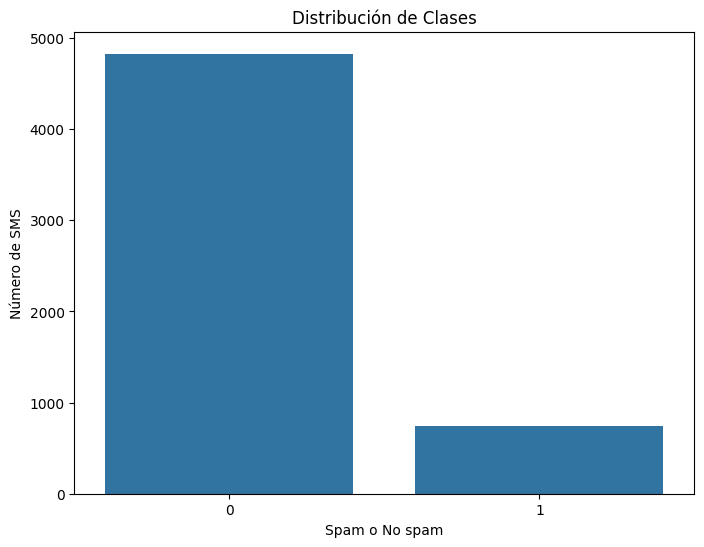

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar la distribución de clases con un countplot
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.xlabel('Spam o No spam')
plt.ylabel('Número de SMS')
plt.title('Distribución de Clases')
plt.show()

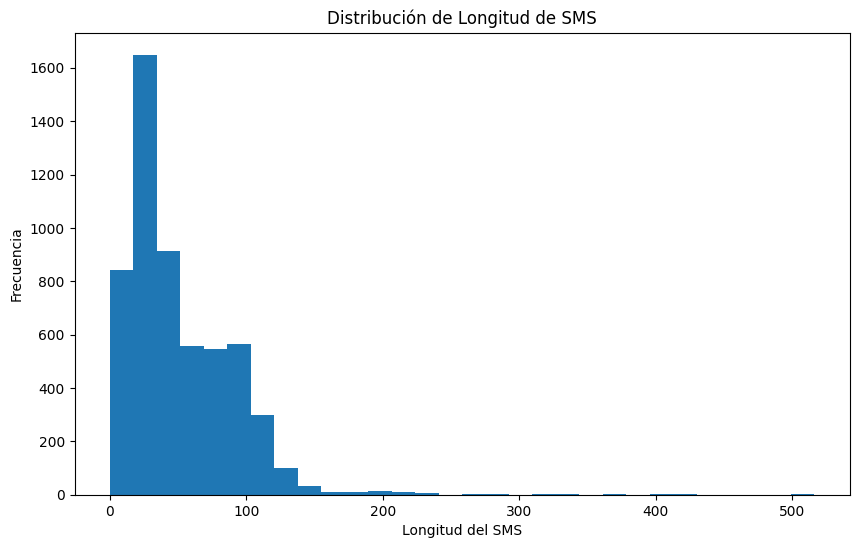

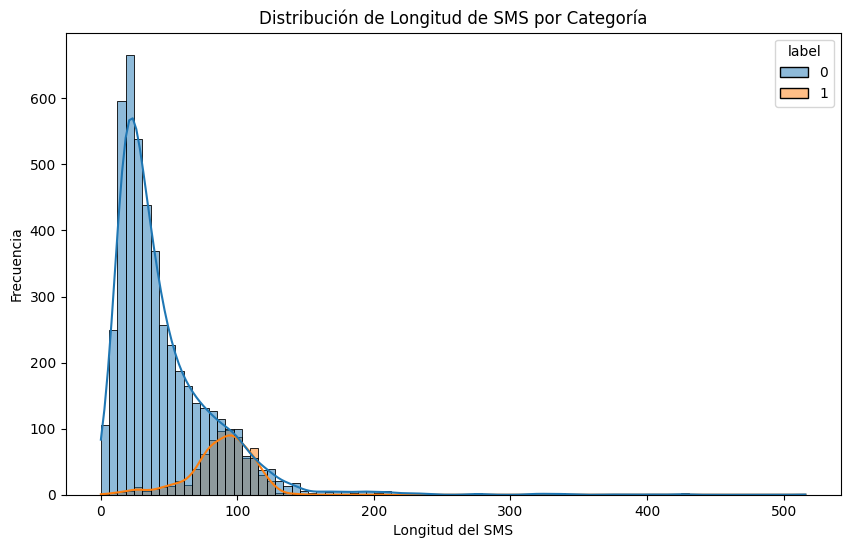

In [ ]:
# Análisis de la distribución de la longitud de los SMS

# Crear una nueva columna con la longitud (en caracteres) de los SMS
df['length'] = df['text'].apply(len)

# Definir el rango común para los bins
min_length = df['length'].min()
max_length = df['length'].max()

# Generar histograma para todos los SMS (30 bins, asegurando que el binrange está entre nuestra longitud mínima y máxima)
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=30, range=(min_length, max_length))
plt.xlabel('Longitud del SMS')
plt.ylabel('Frecuencia')
plt.title('Distribución de Longitud de SMS')

# Comparación de la longitud entre spam y no spam
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='label', kde=True)

# Generar histogramas para SMS de spam y no spam por separado
spam_lengths = df[df['label'] == 1]['length']
no_spam_lengths = df[df['label'] == 0]['length']
plt.title('Distribución de Longitud de SMS por Categoría')
plt.xlabel('Longitud del SMS')
plt.ylabel('Frecuencia')

# Eliminar la columna 'length' después del análisis
df.drop('length', axis=1, inplace=True)

#Los mensajes que son spam suelen requerir de una mayor cantidad de caracteres

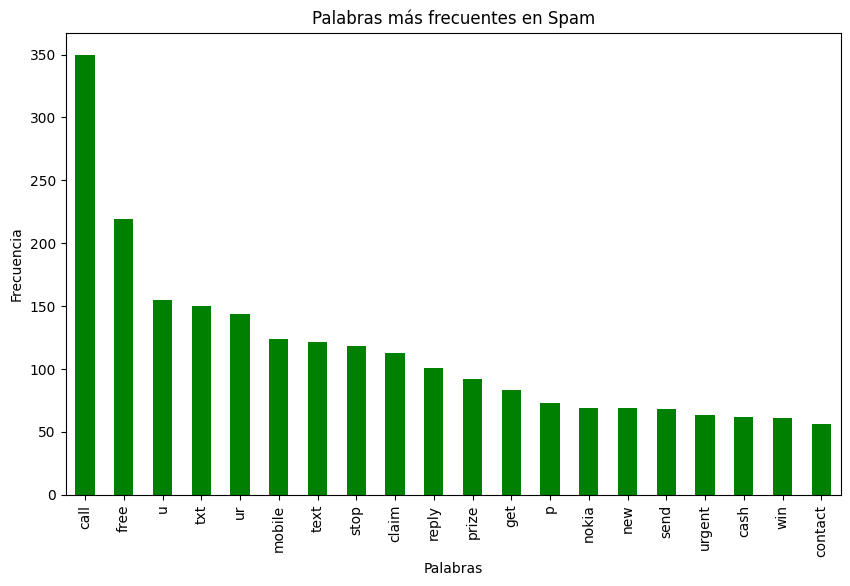

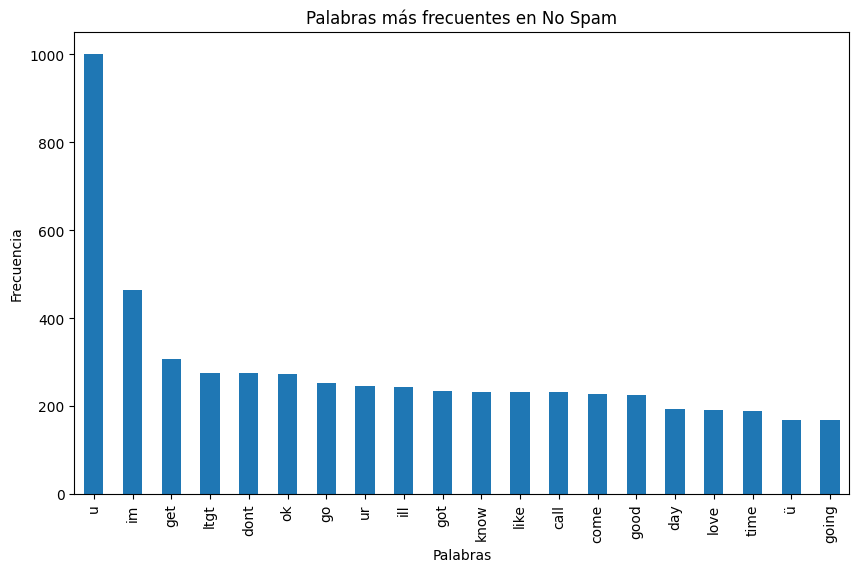

In [ ]:
# Análisis de palabras más frecuentes

# Separar mensajes de spam y no spam
spam_text = ' '.join(df[df['label']==1]['text'].values)
no_spam_text = ' '.join(df[df['label']==0]['text'].values)

# Contar palabras en cada categoría
spam_words = pd.Series(spam_text.split()).value_counts()
no_spam_words = pd.Series(no_spam_text.split()).value_counts()

# Gráfico con las 20 palabras más frecuentes en spam
plt.figure(figsize=(10, 6))
spam_words.head(20).plot(kind='bar',color='green')
plt.title('Palabras más frecuentes en Spam')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()
# Gráfico con las 20 palabras más frecuentes en no spam
plt.figure(figsize=(10, 6))
no_spam_words.head(20).plot(kind='bar')
plt.title('Palabras más frecuentes en No Spam')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.show()

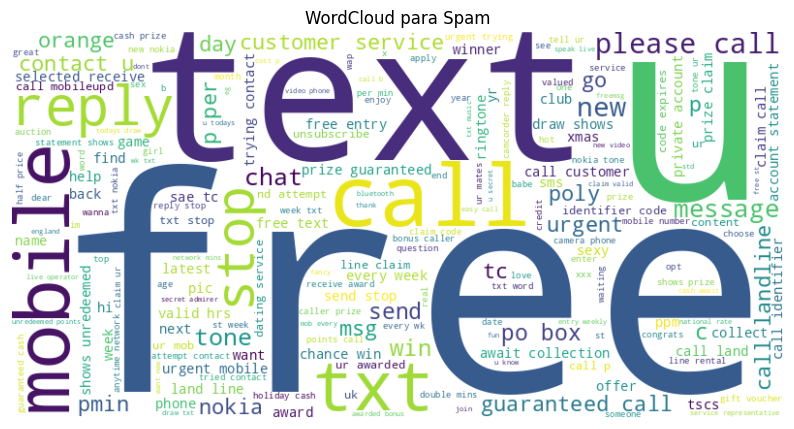

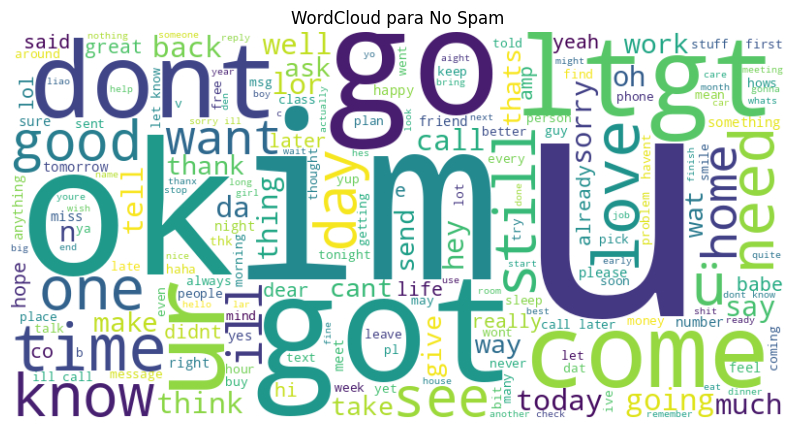

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Generar WordCloud para spam
spam_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(spam_text)

# Generar WordCloud para no spam
no_spam_wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(no_spam_text)

# Mostrar WordCloud para Spam (plt.imshow)
plt.figure(figsize=(10, 6))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud para Spam')
plt.show()

# Mostrar WordCloud para No Spam (plt.imshow)
plt.figure(figsize=(10, 6))
plt.imshow(no_spam_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud para No Spam')
plt.show()

## 5. Train-test split
Dividiremos el dataset en conjuntos de entrenamiento y prueba para evaluar el rendimiento de los modelos.  Usaremos una proporción de 80/20 para entrenamiento y prueba, respectivamente, y estratificaremos la división para mantener la proporción de clases en ambos conjuntos.

In [ ]:
from sklearn.model_selection import train_test_split

# División en train/test (test_size de 0.2, seed 42 y estratificando las etiquetas)
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])
#Estratificar nos asegura que haya la misma proporción de spam y no spam en el conjunto de validación.

## 6. Vectorización de los datos
Convertiremos los mensajes de texto a representaciones numéricas que los modelos puedan entender.  Usaremos TF-IDF para ponderar la importancia de las palabras en cada mensaje.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorización (utilizando las 5000 palabras más frecuentes)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## 7. Entrenamiento y Evaluación de Modelos Clásicos
Entrenaremos y evaluaremos varios modelos clásicos de clasificación, como Naive Bayes, Regresión Logística, Random Forest y SVM.  Utilizaremos las métricas de precisión, recall, F1-score y la matriz de confusión para evaluar el rendimiento de los modelos.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Función para mostrar matriz de confusión
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Spam', 'Spam'], yticklabels=['No Spam', 'Spam'])
    plt.title(title)
    plt.xlabel('Predicción Modelo')
    plt.ylabel('Valor Real')
    plt.show()

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.99      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



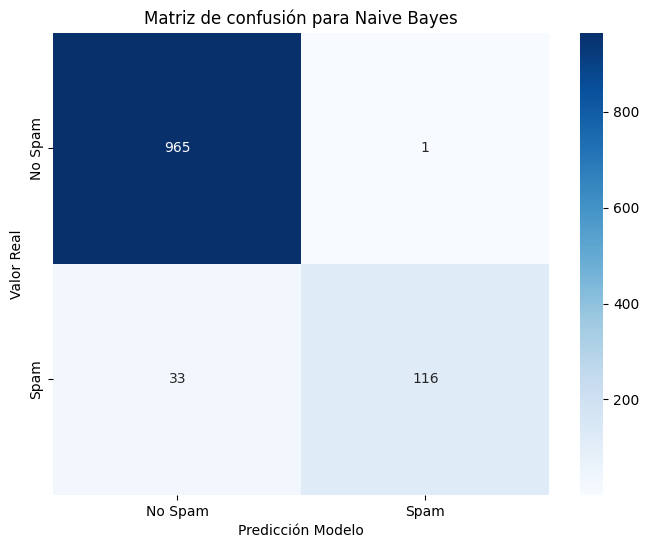

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



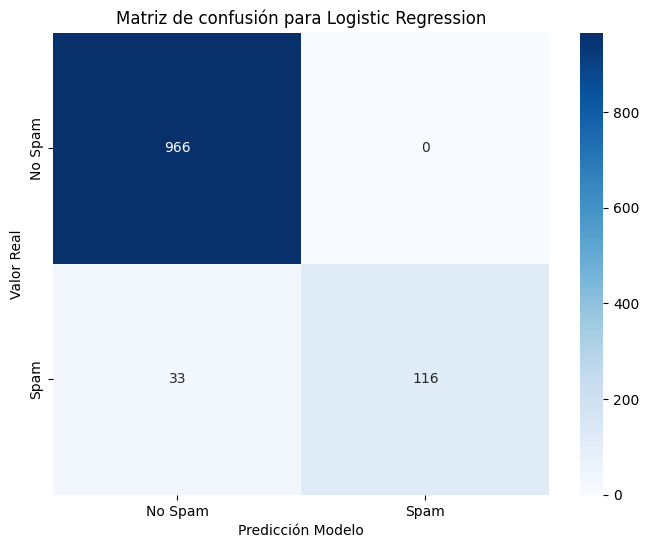

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



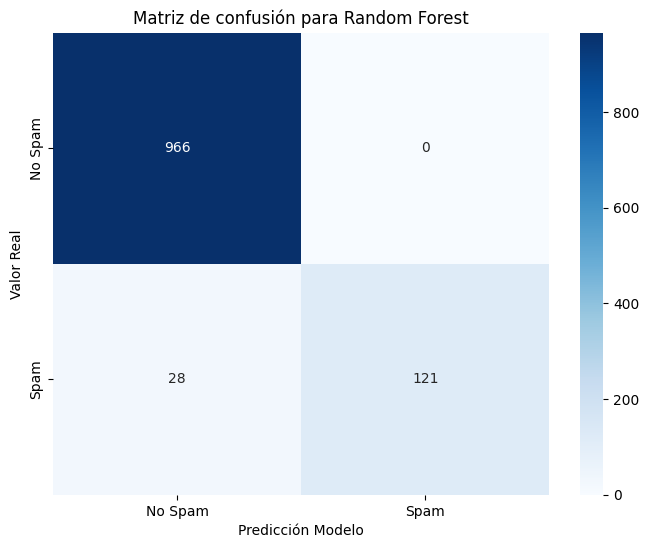

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



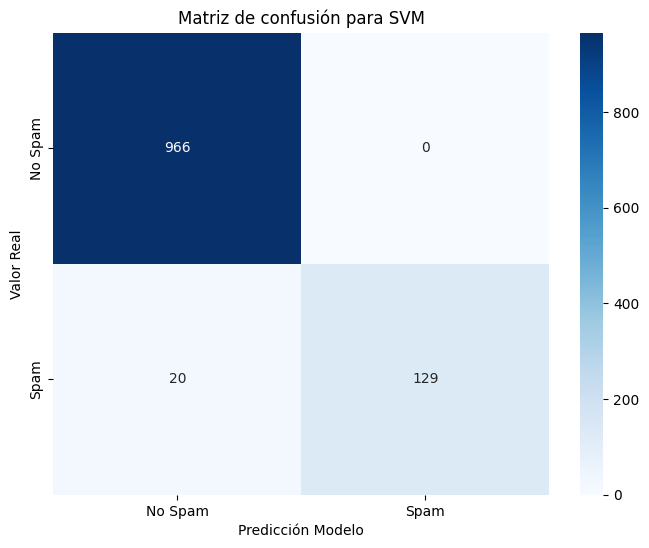

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Modelos clásicos
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

# Iteramos sobre los modelos, entrenándolos con parámetros default, generando predicciones y evaluándolos
for name, model in models.items():
    model.fit(X_train_tfidf,y_train) # Entrenar modelo
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test,y_pred)) # Generar predicciones # Classification report
    plot_confusion_matrix(y_test, y_pred, title=f'Matriz de confusión para {name}') # Matriz de confusión

## 8. Modelo LSTM
Implementaremos un modelo de red neuronal recurrente LSTM para la clasificación de spam.  Este tipo de modelo es adecuado para datos secuenciales como el texto.

In [ ]:
import tensorflow as tf

# Modelo LSTM

# Creamos tokenizador
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000) #Estamos instanciando el tokenizador de keras

# Fit en el set de entrenamiento
tokenizer.fit_on_texts(X_train)

# Convertimos los textos en secuencias de integers
X_train_lstm = tokenizer.texts_to_sequences(X_train)
X_test_lstm = tokenizer.texts_to_sequences(X_test)

# Aseguramos que todas las secuencias tengan una longitud fija para poder ser procesadas por el modelo
X_train_lstm = tf.keras.preprocessing.sequence.pad_sequences(X_train_lstm, maxlen=100)#Se añade un padding para añadir 0 en aquellas secuencias de texto donde no se alcance la long. máxima
X_test_lstm = tf.keras.preprocessing.sequence.pad_sequences(X_test_lstm, maxlen=100)#Si es mayor de 100 la secuencia se trunca

# Construimos el modelo LSTM
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(5000,32), # Capa de embedding, con vocabulario de 5000 palabras que es la inpit_dim,  y 32 de longitud de cada vector denso, es ddecir, el tamaño de la secuencia
    tf.keras.layers.LSTM(64), # Capa LSTM con 64 unidades
    tf.keras.layers.Dense(2,activation = 'softmax') # Capa densa de salida y activación softmax
])

# Compilar el modelo (optimizador 'adam', pérdida 'sparse_categorical_crossentropy' y métrica 'accuracy')
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Imprimir el resumen del modelo
lstm_model.summary()

# Entrenar el modelo por 5 epochs y batch size 32
lstm_model.fit(X_train_lstm, y_train, epochs=5, batch_size=32, validation_data=(X_test_lstm, y_test))

# Predicciones para X_test
y_pred_lstm = lstm_model.predict(X_test_lstm).argmax(axis=1)

# Generar classification report y matriz de confusión
print('Resultados de LSTM:')
print(classification_report(y_test, y_pred_lstm))
accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"Accuracy: {accuracy}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8806 - loss: 0.3552 - val_accuracy: 0.9803 - val_loss: 0.0781
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9825 - loss: 0.0616 - val_accuracy: 0.9821 - val_loss: 0.0606
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9943 - loss: 0.0266 - val_accuracy: 0.9848 - val_loss: 0.0658
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9969 - loss: 0.0149 - val_accuracy: 0.9830 - val_loss: 0.0617
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9977 - loss: 0.0100 - val_accuracy: 0.9848 - val_loss: 0.0701
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Resultados de LSTM:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.90      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98

## 9. Modelo BERT
Finalmente, utilizaremos un modelo pre-entrenado de Transformers, BERT, para la clasificación de spam.  BERT es un modelo de última generación que ha demostrado excelentes resultados en tareas de NLP.  Ajustaremos el modelo a nuestro dataset y lo evaluaremos.

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
279/279 [==============================] - 253s 831ms/step - loss: 0.0865 - accuracy: 0.9686 - val_loss: 0.0331 - val_accuracy: 0.9910
Epoch 2/3
279/279 [==============================] - 231s 827ms/step - loss: 0.0167 - accuracy: 0.9951 - val_loss: 0.0372 - val_accuracy: 0.9910
Epoch 3/3
70/70 [==============================] - 21s 246ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       966
           1       0.98      0.96      0.97       149

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115

Accuracy: 0.9919282511210762


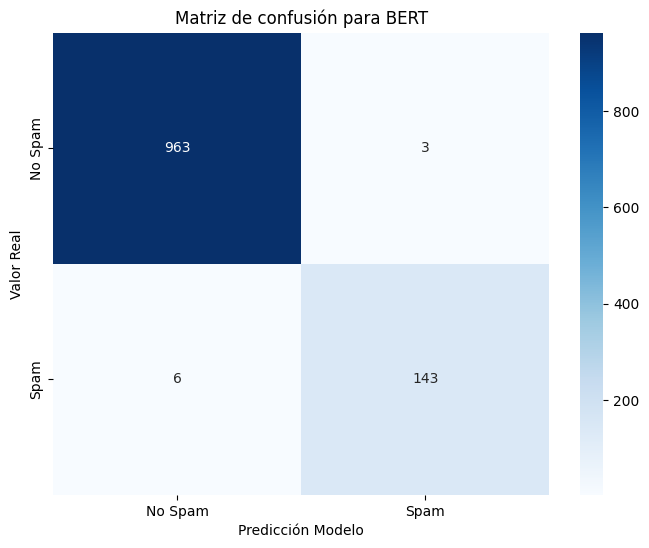

In [ ]:
from transformers import TFBertForSequenceClassification, BertTokenizer, AdamWeightDecay
from sklearn.model_selection import train_test_split
import numpy as np

# Cargar y prepara de nuevo el dataset (las transformaciones para BERT no son similares a las de modelos clásicos)
dataset = load_dataset('sms_spam')
df = pd.DataFrame(dataset['train'])
df = df[['label', 'sms']]
df.rename(columns={'sms': 'text'}, inplace=True)
df['label'] = df['label'].astype(int)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Inicializar tokenizador y modelo BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Definir función para el encoding
def encode_data(texts, labels):
    encodings = tokenizer(texts.tolist(), truncation=True, padding=True, return_tensors='tf')
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset

# Encoding
train_dataset = encode_data(train_df['text'], train_df['label'])
test_dataset = encode_data(test_df['text'], test_df['label'])

# Configurar optimizador y pérdida
optimizer = AdamWeightDecay(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compilar el modelo
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Batching de los datasets
batch_size = 16
train_dataset = train_dataset.shuffle(len(train_df)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Entrenar el modelo por 3 epochs
epochs = 3
model.fit(train_dataset, epochs=epochs, validation_data = test_dataset)

# Evaluar el modelo
predictions = model.predict(test_dataset)
y_pred = tf.argmax(predictions.logits, axis=-1).numpy()
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Generar classification report y matriz de confusión
print(classification_report(y_true,y_pred)) # Classification report
accuracy = accuracy_score(y_true,y_pred) # Accuracy
print(f"Accuracy: {accuracy}")
plot_confusion_matrix(y_true, y_pred, title='Matriz de confusión para BERT') # Matriz de confusión

## 10. Predicciones con nuevos datos
En esta última sección, utilizaremos el modelo BERT entrenado para realizar predicciones en nuevos mensajes SMS.

In [ ]:
# Generar predicciones en nuevos datos
new_sms_messages = ["This is a test message.", "Free tickets! Reply with your name and ID."]

# Procesar los nuevos datos
new_encodings = tokenizer(new_sms_messages, truncation=True, padding=True, return_tensors='tf')
new_predictions = model(new_encodings)

# Generar predicciones para los nuevos datos
predicted_classes = _____
predictions_dict = {message: class_pred for message, class_pred in zip(new_sms_messages, predicted_classes)}
print(predictions_dict)

**CLASIFICACIÓN PARA PROBLEMA MULTICLASE**

Preprocesado de los datos // con modelo ya preentrenado, de ahí que cargemos los pesos

In [ ]:
# Change text for numerical ids and pad
X_novel = tokenizer.texts_to_sequences(news_novel.data)
X_novel = pad_sequences(X_novel, maxlen=400)

# One-hot encode the labels
Y_novel = to_categorical(news_novel.target)

# Load the model pre-trained weights
model.load_weights('classify_news_weights.h5')

# Evaluate the model on the new dataset
loss, acc = model.evaluate(X_novel, Y_novel, batch_size=64)

# Print the loss and accuracy obtained
print("Loss:\t{0}\nAccuracy:\t{1}".format(loss, acc))